In [205]:
import nltk
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import joblib
import contractions

# Load Dataset

---



In [170]:
sms = pd.read_csv("SMSSpamCollection[1]", sep='\t', header=None, names=['label', 'message'])
sms.head(7)

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.


# Data Exploration

---



In [171]:
sms.shape
#sms.describe()
#sms.info()

(5572, 2)

In [172]:
#sms.label.value_counts()
(round(sms.label.value_counts(normalize=True),2))*100

,proportion
label,
ham,87.0
spam,13.0


In [173]:
sms.groupby('label').describe()

message         \
        count unique   
label                  
ham      4825   4516   
spam      747    653   

                                                                                                                                                            \
                                                                                                                                                       top   
label                                                                                                                                                        
ham                                                                                                                                 Sorry, I'll call later   
spam   Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed £1000 cash or £5000 prize!   

            
      freq  
label       
ham     30  
spam     4

In [174]:
sms['Length'] = sms['message'].apply(len)
sms.head()

,label,message,Length
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives around here though",61


This histogram shows that the length of messages is relevant when detecting spam messages.

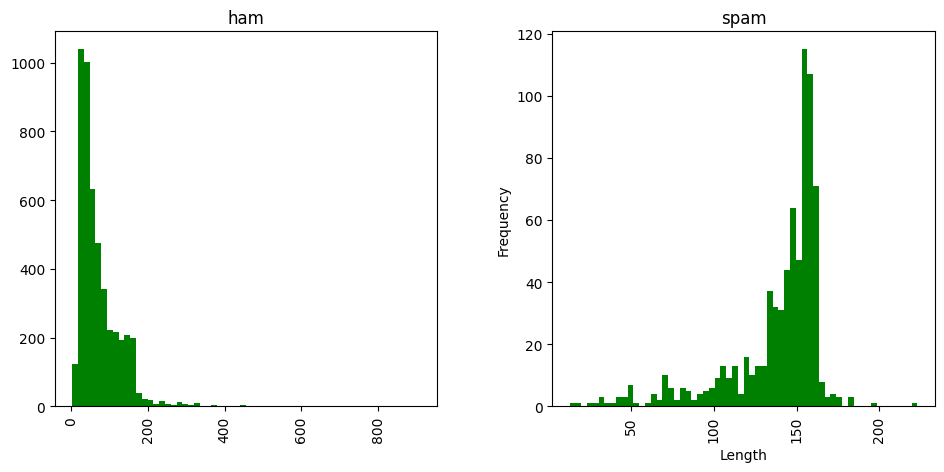

In [176]:
sms.hist(column='Length', by='label', bins=60, color="green",figsize = (11,5))
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

<Axes: ylabel='count'>

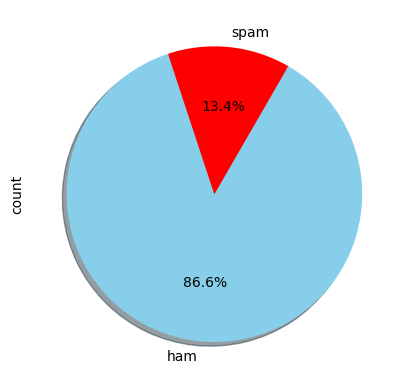

In [175]:
colors = ["skyblue","red"]
sms.label.value_counts().plot.pie(autopct='%1.1f%%', shadow=True , startangle =60,counterclock =False ,colors=colors )

# 1. Text Preprocessing

---



In [177]:
#!pip install contractions
def preprocess_text(text):
    text = contractions.fix(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^\w\s!?]", "", text)
    text = text.lower().strip()
    return text

corpus = [preprocess_text(text) for text in sms['message']]
sms['filtered_message']=sms['message'].apply(preprocess_text)
pd.set_option('display.max_colwidth', 100)
sms.head(7)

,label,message,Length,filtered_message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",111,go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif you oni
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,155,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...
3,ham,U dun say so early hor... U c already then say...,49,you dun say so early hor you c already then say
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,nah i do not think he goes to usf he lives around here though
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,147,freemsg hey there darling it is been 3 weeks now and no word back! i would like some fun you up ...
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.,77,even my brother is not like to speak with me they treat me like aids patent


# 2. Tokenization

---



In [178]:
from nltk.tokenize import word_tokenize
def tokenize_text(text):
    tokens= word_tokenize(text)
    return tokens
sms['tokenized_message'] = sms['filtered_message'].apply(tokenize_text)
sms.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,label,message,Length,filtered_message,tokenized_message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",111,go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, ci..."
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif you oni,"[ok, lar, joking, wif, you, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,155,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to..."
3,ham,U dun say so early hor... U c already then say...,49,you dun say so early hor you c already then say,"[you, dun, say, so, early, hor, you, c, already, then, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,nah i do not think he goes to usf he lives around here though,"[nah, i, do, not, think, he, goes, to, usf, he, lives, around, here, though]"


# 3. Stopword Removal

---



In [179]:
from nltk.corpus import stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens
sms['stopwords_removed'] = sms['tokenized_message'].apply(lambda x : remove_stopwords(x))
sms.head(7)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,message,Length,filtered_message,tokenized_message,stopwords_removed
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",111,go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, ci...","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]"
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif you oni,"[ok, lar, joking, wif, you, oni]","[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,155,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv..."
3,ham,U dun say so early hor... U c already then say...,49,you dun say so early hor you c already then say,"[you, dun, say, so, early, hor, you, c, already, then, say]","[dun, say, early, hor, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,nah i do not think he goes to usf he lives around here though,"[nah, i, do, not, think, he, goes, to, usf, he, lives, around, here, though]","[nah, think, goes, usf, lives, around, though]"
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,147,freemsg hey there darling it is been 3 weeks now and no word back! i would like some fun you up ...,"[freemsg, hey, there, darling, it, is, been, 3, weeks, now, and, no, word, back, !, i, would, li...","[freemsg, hey, darling, 3, weeks, word, back, !, would, like, fun, still, ?, tb, ok, !, xxx, std..."
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.,77,even my brother is not like to speak with me they treat me like aids patent,"[even, my, brother, is, not, like, to, speak, with, me, they, treat, me, like, aids, patent]","[even, brother, like, speak, treat, like, aids, patent]"


# 4. Lemmatization

---



In [180]:
def lemmatize_text(text):
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_words
sms['lemmatized_message'] = sms['stopwords_removed'].apply(lemmatize_text)
sms.head(7)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,label,message,Length,filtered_message,tokenized_message,stopwords_removed,lemmatized_message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",111,go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, ci...","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]"
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif you oni,"[ok, lar, joking, wif, you, oni]","[ok, lar, joking, wif, oni]","[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,155,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv..."
3,ham,U dun say so early hor... U c already then say...,49,you dun say so early hor you c already then say,"[you, dun, say, so, early, hor, you, c, already, then, say]","[dun, say, early, hor, c, already, say]","[dun, say, early, hor, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,nah i do not think he goes to usf he lives around here though,"[nah, i, do, not, think, he, goes, to, usf, he, lives, around, here, though]","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, life, around, though]"
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,147,freemsg hey there darling it is been 3 weeks now and no word back! i would like some fun you up ...,"[freemsg, hey, there, darling, it, is, been, 3, weeks, now, and, no, word, back, !, i, would, li...","[freemsg, hey, darling, 3, weeks, word, back, !, would, like, fun, still, ?, tb, ok, !, xxx, std...","[freemsg, hey, darling, 3, week, word, back, !, would, like, fun, still, ?, tb, ok, !, xxx, std,..."
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.,77,even my brother is not like to speak with me they treat me like aids patent,"[even, my, brother, is, not, like, to, speak, with, me, they, treat, me, like, aids, patent]","[even, brother, like, speak, treat, like, aids, patent]","[even, brother, like, speak, treat, like, aid, patent]"


# Cleaned Text Creation

---



In [181]:
def clean_text(text):
  text = preprocess_text(text)
  tokens = tokenize_text(text)
  filtered_tokens = remove_stopwords(tokens)
  lemmatized_tokens = lemmatize_text(filtered_tokens)
  return " ".join(lemmatized_tokens)
sms=sms[['label' , 'message']]
sms['cleaned_text'] = sms['message'].apply(clean_text)
sms.head(7)

,label,message,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go jurong point crazy available bugis n great world la e buffet cine got amore wat
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questions...
3,ham,U dun say so early hor... U c already then say...,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives around here though",nah think go usf life around though
5,spam,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...,freemsg hey darling 3 week word back ! would like fun still ? tb ok ! xxx std chgs send 150 rcv
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.,even brother like speak treat like aid patent


In [182]:
from collections import Counter
ham_count = Counter(" ".join(sms[sms['label']=='ham']["cleaned_text"]).split()).most_common(20)
ham_count_df = pd.DataFrame.from_dict(ham_count)
ham_count_df = ham_count_df.rename(columns={0: "words in ham", 1 : "count"})

spam_count = Counter(" ".join(sms[sms['label']=='spam']["cleaned_text"]).split()).most_common(20)
spam_count_df = pd.DataFrame.from_dict(spam_count)
spam_count_df = spam_count_df.rename(columns={0: "words in spam", 1 : "count_"})

In [183]:
print(ham_count_df[0:20])
print('\n',spam_count_df[0:20])

   words in ham  count
0             ?   1375
1             !    852
2           get    314
3             2    310
4          know    277
5            go    276
6          ltgt    276
7            ok    274
8          come    245
9           got    244
10         call    243
11         like    235
12         love    233
13        going    232
14         good    225
15          day    215
16         time    214
17         want    212
18            4    174
19            ü    173

    words in spam  count_
0              !     545
1           call     359
2           free     216
3              2     174
4              ?     174
5            txt     156
6           text     137
7         mobile     135
8              4     122
9           stop     118
10         claim     115
11         reply     105
12         prize      94
13           get      84
14          tone      74
15       service      72
16       message      70
17          send      69
18           new      69
19         noki

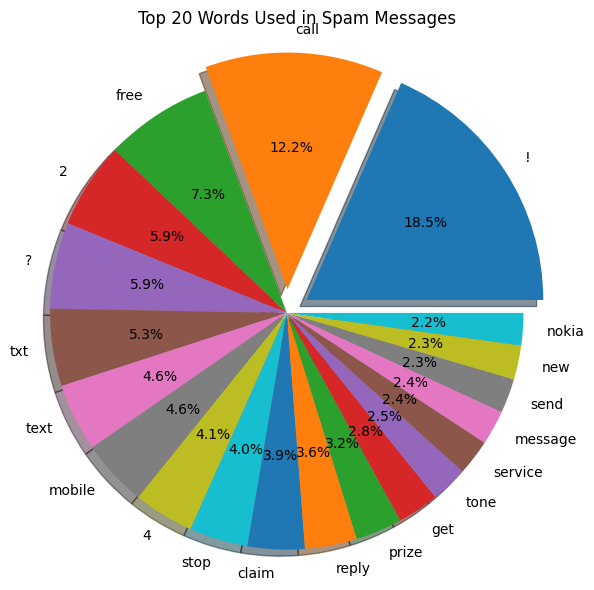

In [184]:
explode = (0.1, 0.1, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))
plt.pie(spam_count_df['count_'],
       labels = spam_count_df["words in spam"],
       shadow = True,
       autopct='%1.1f%%',
       explode = explode)
plt.title("Top 20 Words Used in Spam Messages")
plt.axis('equal')
plt.show()

# TF-IDF Vectorization

---



In [185]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
features = tfidf.fit_transform(sms['cleaned_text'])
print(features.shape)
print('Sparse Matrix\n',features)
features=pd.DataFrame( features.toarray())
features.columns=tfidf.get_feature_names_out()
features

(5572, 5000)
Sparse Matrix
   (0, 1828)	0.19280618784697118
  (0, 3397)	0.29676226568481107
  (0, 1232)	0.33657708055783164
  (0, 517)	0.3304872791433268
  (0, 761)	0.36716197810013035
  (0, 1910)	0.24189899802860845
  (0, 4904)	0.29535187969667226
  (0, 2381)	0.36716197810013035
  (0, 1013)	0.36716197810013035
  (0, 1889)	0.20167702672376855
  (0, 4746)	0.24780379956368728
  (1, 3097)	0.24020627588156612
  (1, 2401)	0.3581429575538954
  (1, 2286)	0.4593205570939584
  (1, 4833)	0.37858267116642874
  (1, 3136)	0.47944465473349734
  (1, 3102)	0.47944465473349734
  (2, 1702)	0.123778640379044
  (2, 1536)	0.3842891820105655
  (2, 4882)	0.20340608641057684
  (2, 1124)	0.2099673942778848
  (2, 4841)	0.15647690111163162
  (2, 1591)	0.5014599237832948
  (2, 1252)	0.21532837315415773
  (2, 1639)	0.19645531619955628
  :	:
  (5567, 3486)	0.17643492111877243
  (5567, 1032)	0.17643492111877243
  (5567, 2800)	0.18606520301027415
  (5567, 56)	0.18606520301027415
  (5567, 3250)	0.18606520301027415
  (

,020603,020603 2nd,020603 2nd attempt,0800,0800 542,08000839402,08000930705,08000930705 delivery,08001950382,08002986906,...,youve invited xchat,yr,yr prize,yr prize call,yun,yuo,yup,yup ok,yup thk,zed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Engineering

---



In [186]:
sms['message_length'] = sms['message'].apply(lambda x: len(x)-x.count(' '))
sms.head()

,label,message,cleaned_text,message_length
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go jurong point crazy available bugis n great world la e buffet cine got amore wat,92
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni,24
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questions...,128
3,ham,U dun say so early hor... U c already then say...,dun say early hor c already say,39
4,ham,"Nah I don't think he goes to usf, he lives around here though",nah think go usf life around though,49


In [187]:
import string
def countpunct(text):
  count=sum([1 for char in text if char in string.punctuation])
  return round(count/(len(text)-text.count(' ')),3)*100
sms['punctuation_count']=sms['message'].apply(countpunct)
sms.head()

,label,message,cleaned_text,message_length,punctuation_count
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go jurong point crazy available bugis n great world la e buffet cine got amore wat,92,9.8
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni,24,25.0
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questions...,128,4.7
3,ham,U dun say so early hor... U c already then say...,dun say early hor c already say,39,15.4
4,ham,"Nah I don't think he goes to usf, he lives around here though",nah think go usf life around though,49,4.1


In [188]:
def countcap(text):
  num_uppercase = sum(1 for char in text if char.isupper())
  total_chars = len(text) - text.count(' ')
  if total_chars == 0:
    return 0
  return round(num_uppercase / total_chars, 3) * 100
sms['capital_count'] = sms['message'].apply(countcap)

In [189]:
sms['numeric_ratio'] = sms['message'].apply(lambda x: (sum(c.isdigit() for c in x) / len(x)))
sms.head()

,label,message,cleaned_text,message_length,punctuation_count,capital_count,numeric_ratio
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go jurong point crazy available bugis n great world la e buffet cine got amore wat,92,9.8,3.3,0.00000
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni,24,25.0,8.3,0.00000
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questions...,128,4.7,7.8,0.16129
3,ham,U dun say so early hor... U c already then say...,dun say early hor c already say,39,15.4,5.1,0.00000
4,ham,"Nah I don't think he goes to usf, he lives around here though",nah think go usf life around though,49,4.1,4.1,0.00000


In [190]:
def words(text):
    odd = ('download', 'Download', 'link', 'Link', 'click here','downloaded','free','call','msg','mobil','text','stop','claim')
    odd_words = sum(1 for word in text.split() if word in odd)
    return odd_words

sms['spam_words'] = sms['message'].apply(words)
x=sms['spam_words'].value_counts()
print(x)

spam_words
0    4929
1     515
2      98
3      25
4       5
Name: count, dtype: int64


# Scaling numerical features

---



In [191]:
scaler = MinMaxScaler()
num_vars = ['message_length','punctuation_count','capital_count','numeric_ratio','spam_words']
scaled_features = pd.DataFrame(scaler.fit_transform(sms[num_vars]), columns=num_vars)
sms.update(scaled_features)
sms.head()

<ipython-input-191-8c8e27fb3eb7>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.12195122 0.0298103  0.17073171 ... 0.06233062 0.13279133 0.02574526]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sms.update(scaled_features)
<ipython-input-191-8c8e27fb3eb7>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.   0.   0.   ... 0.   0.25 0.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sms.update(scaled_features)


,label,message,cleaned_text,message_length,punctuation_count,capital_count,numeric_ratio,spam_words
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go jurong point crazy available bugis n great world la e buffet cine got amore wat,0.121951,0.098,0.033,0.00000,0.0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni,0.029810,0.250,0.083,0.00000,0.0
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questions...,0.170732,0.047,0.078,0.16129,0.0
3,ham,U dun say so early hor... U c already then say...,dun say early hor c already say,0.050136,0.154,0.051,0.00000,0.0
4,ham,"Nah I don't think he goes to usf, he lives around here though",nah think go usf life around though,0.063686,0.041,0.041,0.00000,0.0


# Label Encoding

---



In [192]:
sms['label'] = sms['label'].map({'ham': 0, 'spam': 1})

# Preparing Data for Model Training

---



In [193]:
target = sms['label']
final_df = sms.drop(['label', 'message', 'cleaned_text'], axis=1)

In [194]:
final_df=pd.concat([final_df,pd.DataFrame(features)],axis=1)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(final_df, target, test_size=0.25,random_state=42)

# Handling Imbalance with SMOTE

---



In [196]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled class distribution: {y_resampled.value_counts()}")

Resampled class distribution: label
1    3618
0    3618
Name: count, dtype: int64


# Model Training - RandomForest

---



In [197]:
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)
model.score(X_resampled, y_resampled)

1.0

In [198]:
rf = RandomForestClassifier(n_jobs=1, n_estimators=400)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9834888729361091

# Model Training - Logistic Regression

---



In [206]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_resampled, y_resampled)
print(f"Logistic Regression Training Accuracy: {lr_model.score(X_resampled, y_resampled)}")
print(f"Logistic Regression Test Accuracy: {lr_model.score(X_test, y_test)}")

Logistic Regression Training Accuracy: 0.9926755113322278
Logistic Regression Test Accuracy: 0.9870782483847811


# Cross-Validation

---



In [199]:
rf= RandomForestClassifier (n_jobs=1)
k_fold = KFold(n_splits=5)
cross_val_score (rf, final_df, target, cv=k_fold, scoring='accuracy', n_jobs=1)

array([0.98475336, 0.99103139, 0.98114901, 0.97666068, 0.98114901])

# Model Evaluation

---



In [200]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1205    2]
 [  11  175]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1207
           1       0.99      0.94      0.96       186

    accuracy                           0.99      1393
   macro avg       0.99      0.97      0.98      1393
weighted avg       0.99      0.99      0.99      1393



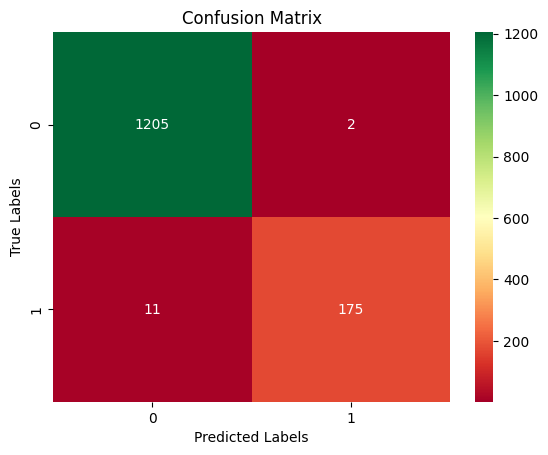

In [201]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='RdYlGn')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Misclassified Messages Analysis

---



In [203]:
y_pred_prob = model.predict_proba(X_test)[:, 1]
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Probability': y_pred_prob})
misclassified = df_results[df_results['Actual'] != df_results['Predicted']]
print(misclassified.head(20))

      Actual  Predicted  Probability
881        1          0         0.28
2402       1          0         0.36
2663       1          0         0.11
751        1          0         0.05
1612       0          1         0.74
4376       1          0         0.50
2313       1          0         0.33
3885       1          0         0.34
3360       1          0         0.49
3443       1          0         0.22
2770       1          0         0.43
263        0          1         0.53
68         1          0         0.11


In [204]:
pd.set_option('display.max_colwidth', None)
print(sms.iloc[misclassified.index][['message']])

                                                                                                                                                        message
881                             Reminder: You have not downloaded the content you have already paid for. Goto http://doit. mymoby. tv/ to collect your content.
2402   Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs)
2663                         Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?
751                                                      Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
1612                                                                                                                                                        645
4376          Ur TONEXS subscription has